In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from math import pi
from joblib import Parallel, delayed

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

Matplotlib is building the font cache; this may take a moment.


# Functions

In [2]:
def adjustFontsize(width_in):
    base_size = 12
    scale_factor = width_in / 6
    return base_size * scale_factor

def adjustFigsize(width_in, aspect_ratio=1.6):
    height_in = width_in / aspect_ratio
    return (width_in, height_in)

def compute_silhouette(k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(lineupStatsScaled)
    score = silhouette_score(lineupStatsScaled, kmeans.labels_)
    return score

# Load and Prepare Lineup Data

In [5]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
lineup_folder = os.path.join(base_dir, "data", "lineup_stats")

lineupDataSeasons = []
seasons = ['2020-21', '2021-22', '2022-23', '2023-24']

for season in seasons:
    filename = f"lineup_stats_{season}with_static.pkl"
    open_path = os.path.join(lineup_folder, filename)
    seasonData = pd.read_pickle(open_path)
    lineupDataSeasons.append(seasonData)

lineupData = pd.concat(lineupDataSeasons).reset_index(drop=True)

selected_statistics = [
    "E_OFF_RATING", "PCT_FGA_2PT", "PCT_FGA_3PT", "PCT_PTS_PAINT", "PCT_PTS_FB",
    "EFG_PCT", "TM_TOV_PCT",
    "REB_PCT", "OREB_PCT", "DREB_PCT",
    "E_DEF_RATING", "OPP_PTS_FB", "OPP_TOV_PCT", "OPP_FTA_RATE"
]

selected_statistics_home = [f"{stat}_home" for stat in selected_statistics]
selected_statistics_away = [f"{stat}_away" for stat in selected_statistics]

homeLineups = lineupData[selected_statistics_home].dropna()
awayLineups = lineupData[selected_statistics_away].dropna()

homeLineups = homeLineups.rename(columns={f"{stat}_home": stat for stat in selected_statistics})
awayLineups = awayLineups.rename(columns={f"{stat}_away": stat for stat in selected_statistics})

homeLineups['side'] = 'home'
awayLineups['side'] = 'away'
homeLineups['index'] = homeLineups.index
awayLineups['index'] = awayLineups.index

combinedLineupStats = pd.concat([homeLineups, awayLineups])

lineup_stats_columns = combinedLineupStats.columns.difference(['side', 'index'])

# Standardize the lineup statistics for kmeans clustering
scaler = StandardScaler()
lineupStatsScaled = scaler.fit_transform(combinedLineupStats[lineup_stats_columns])

combinedLineupStatsScaled = pd.DataFrame(lineupStatsScaled, columns=lineup_stats_columns, index=combinedLineupStats.index)
combinedLineupStatsScaled['side'] = combinedLineupStats['side']
combinedLineupStatsScaled['index'] = combinedLineupStats['index']

# Elbow Curve for Optimal K Clusters

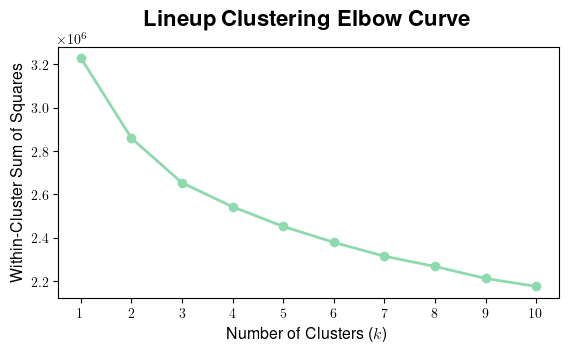

In [6]:
pagewidth = 5.78851
figsize = adjustFigsize(pagewidth, aspect_ratio=1.6)
fontsize = adjustFontsize(pagewidth)

wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(lineupStatsScaled)
    wss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
ax.plot(range(1, 11), wss, marker='o', linestyle='-', color='#8FD9AF', linewidth=2)

ax.set_xlabel(r'Number of Clusters ($k$)', fontsize=fontsize)
ax.set_ylabel(r'Within-Cluster Sum of Squares', fontsize=fontsize)
ax.set_title(r'\textbf{Lineup Clustering Elbow Curve}', fontsize=16, pad=15)

ax.tick_params(axis='both', which='both',
               direction='out',
               colors='black', bottom=True, left=True)

ax.set_xticks(range(1, 11))

for spine in ax.spines.values():
    spine.set_edgecolor('black')

plt.grid(False)
plt.tight_layout()
plt.show()

# Silhouette Scores

In [ ]:
silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_silhouette)(k) for k in range(1, 11))

In [ ]:
fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
ax.plot(range(1, 11), silhouette_scores, marker='o', linestyle='-', color='#8FD9AF', linewidth=2)

ax.set_xlabel(r'Number of Clusters ($k$)', fontsize=fontsize)
ax.set_ylabel(r'Silhouette Score', fontsize=fontsize)
ax.set_title(r'\textbf{Silhouette Score for Optimal $K$}', fontsize=16, pad=15)

ax.tick_params(axis='both', which='both',
               direction='out',
               colors='black', bottom=True, left=True)

ax.set_xticks(range(1, 11))

for spine in ax.spines.values():
    spine.set_edgecolor('black')


plt.grid(False)
plt.tight_layout()
plt.show()

# KMeans Cluster k=3

In [7]:
# Cluster the lineup statistics using KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(lineupStatsScaled)

# Assign cluster labels to both raw lineup stats and scaled lineup stats
combinedLineupStats['cluster'] = kmeans.labels_
combinedLineupStatsScaled['cluster'] = kmeans.labels_

clusterCenters = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=lineup_stats_columns)

print("\nNumber of lineups in each cluster:")
print(combinedLineupStats['cluster'].value_counts())


Number of lineups in each cluster:
cluster
1    84122
0    77553
2    68933
Name: count, dtype: int64


# Radar Chart

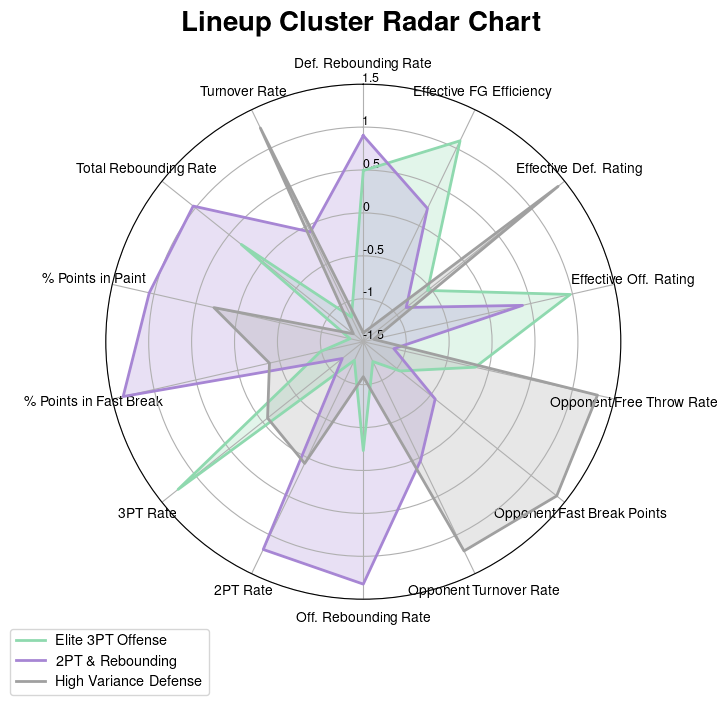

In [8]:
pagewidth = 5.78851
figsize = adjustFigsize(pagewidth, aspect_ratio=1.6)
fontsize = adjustFontsize(pagewidth)


scaler = StandardScaler()
scaled_cluster_centers = scaler.fit_transform(clusterCenters)
scaledDfPlot = pd.DataFrame(scaled_cluster_centers, columns=clusterCenters.columns)

cluster_labels = [r'Elite 3PT Offense', r'2PT \& Rebounding', r'High Variance Defense']
formatted_labels = {
    'DREB_PCT': r'Def. Rebounding Rate',
    'EFG_PCT': r'Effective FG Efficiency',
    'E_DEF_RATING': r'Effective Def. Rating',
    'E_OFF_RATING': r'Effective Off. Rating',
    'OPP_FTA_RATE': r'Opponent Free Throw Rate',
    'OPP_PTS_FB': r'Opponent Fast Break Points',
    'OPP_TOV_PCT': r'Opponent Turnover Rate',
    'OREB_PCT': r'Off. Rebounding Rate',
    'PCT_FGA_2PT': r'2PT Rate',
    'PCT_FGA_3PT': r'3PT Rate',
    'PCT_PTS_FB': r'\% Points in Fast Break',
    'PCT_PTS_PAINT': r'\% Points in Paint',
    'REB_PCT': r'Total Rebounding Rate',
    'TM_TOV_PCT': r'Turnover Rate'
}
colors = ['#8FD9AF', '#A786D4', '#A0A0A0']

labels = [formatted_labels[col] for col in clusterCenters.columns]
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(figsize[0]*2, figsize[1]*2), subplot_kw=dict(polar=True))
for i, row in scaledDfPlot.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=cluster_labels[i], color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.tick_params(colors='black')
radial_ticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
ax.set_yticks(radial_ticks)
ax.set_yticklabels([str(t) for t in radial_ticks], fontsize=9)
ax.set_ylim(-1.5, 1.5)

ax.set_title(r'\textbf{Lineup Cluster Radar Chart}', fontsize=20, pad=20)
ax.legend(loc='lower left', bbox_to_anchor=(-0.2, -0.2), frameon=True, fontsize = fontsize*0.9)

plt.tight_layout()
plt.show()

# Assign Clusters Back to Time Intervals

In [9]:
clusterCenters.columns.to_list()
home_clusters = combinedLineupStatsScaled[combinedLineupStatsScaled['side'] == 'home'][['index', 'cluster']]
away_clusters = combinedLineupStatsScaled[combinedLineupStatsScaled['side'] == 'away'][['index', 'cluster']]

lineupData = lineupData.merge(home_clusters[['index', 'cluster']], how='left', left_index=True,
                                                right_on='index', suffixes=('', '_home'))
lineupData.rename(columns={'cluster': 'lineup_cluster_home'}, inplace=True)


lineupData = lineupData.merge(away_clusters[['index', 'cluster']], how='left', left_index=True,
                                                right_on='index', suffixes=('', '_away'))
lineupData.rename(columns={'cluster': 'lineup_cluster_away'}, inplace=True)

lineupData.drop(columns=['index', 'index_away'], inplace=True)